In [1]:
# Configure matplotlib.
%matplotlib inline

In [2]:
# Import our package.
import sys, importlib
sys.path.append("/home/ubuntu/cell_counting")

from src import dataset, visualization, preprocess, metric, losses
from src.model import model
from src.model import neural_net
from src.model.segmentation.convnet1 import convnet1
from IPython import display

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
# (if changes are made) Re-import our package.
for module in (dataset, visualization, preprocess, metric, model, neural_net, convnet1, losses):
    importlib.reload(module)

In [3]:
# Load the dataset, processing it as a collection of image-mask pairs.
images_masks = dataset.Dataset(1)
images_masks.load_image_mask_pairs("/home/ubuntu/cell_counting/data/easy/raw/images",
                                   "/home/ubuntu/cell_counting/data/easy/raw/masks", (2448*2, 2448*2))

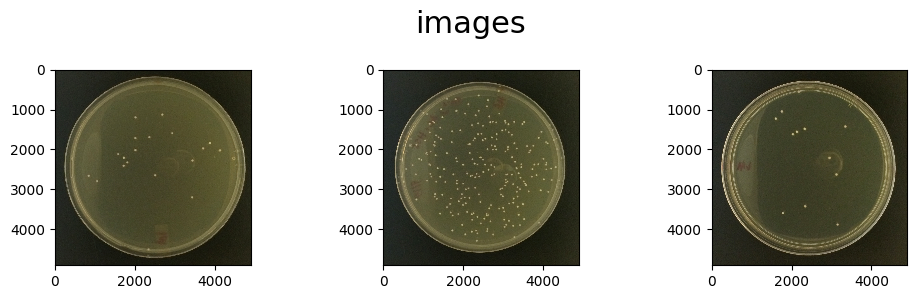

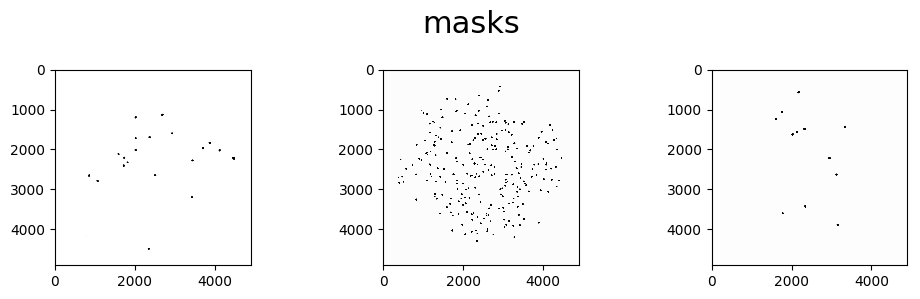

In [4]:
# Plot a batch.
inputs, outputs = images_masks.get_batch(3)
visualization.show_image_grid(inputs, 1, 3, 3, 10, "images")
visualization.show_image_grid(outputs, 1, 3, 3, 10, "masks")

In [ ]:
# Normalize the images.
#def normalize(batch):
#    inputs, outputs = batch
#    inputs = preprocess.smdm_normalize(inputs, 61, "REFLECT")
#    return (inputs, outputs)
#images_masks.map_batch(normalize)

In [ ]:
# Plot a batch.
#inputs, outputs = images_masks.get_batch(3)
#visualization.show_image_grid(inputs, 1, 3, 2, 6, "images")
#visualization.show_image_grid(outputs, 1, 3, 2, 6, "masks")

In [5]:
# Extract patches from the images.
def extract_patches(example):
    input_, output = example
    input_ = preprocess.extract_patches(input_, 61, 100000)
    output = preprocess.extract_patches(output, 61, 100000)
    examples = [(input_[i, ...] / 255, 0 if all(output[i, 61//2 + 1, 61//2 + 1] > 200) else 1) for i in range(input_.shape[0])]
    return examples
images_masks.map(extract_patches)

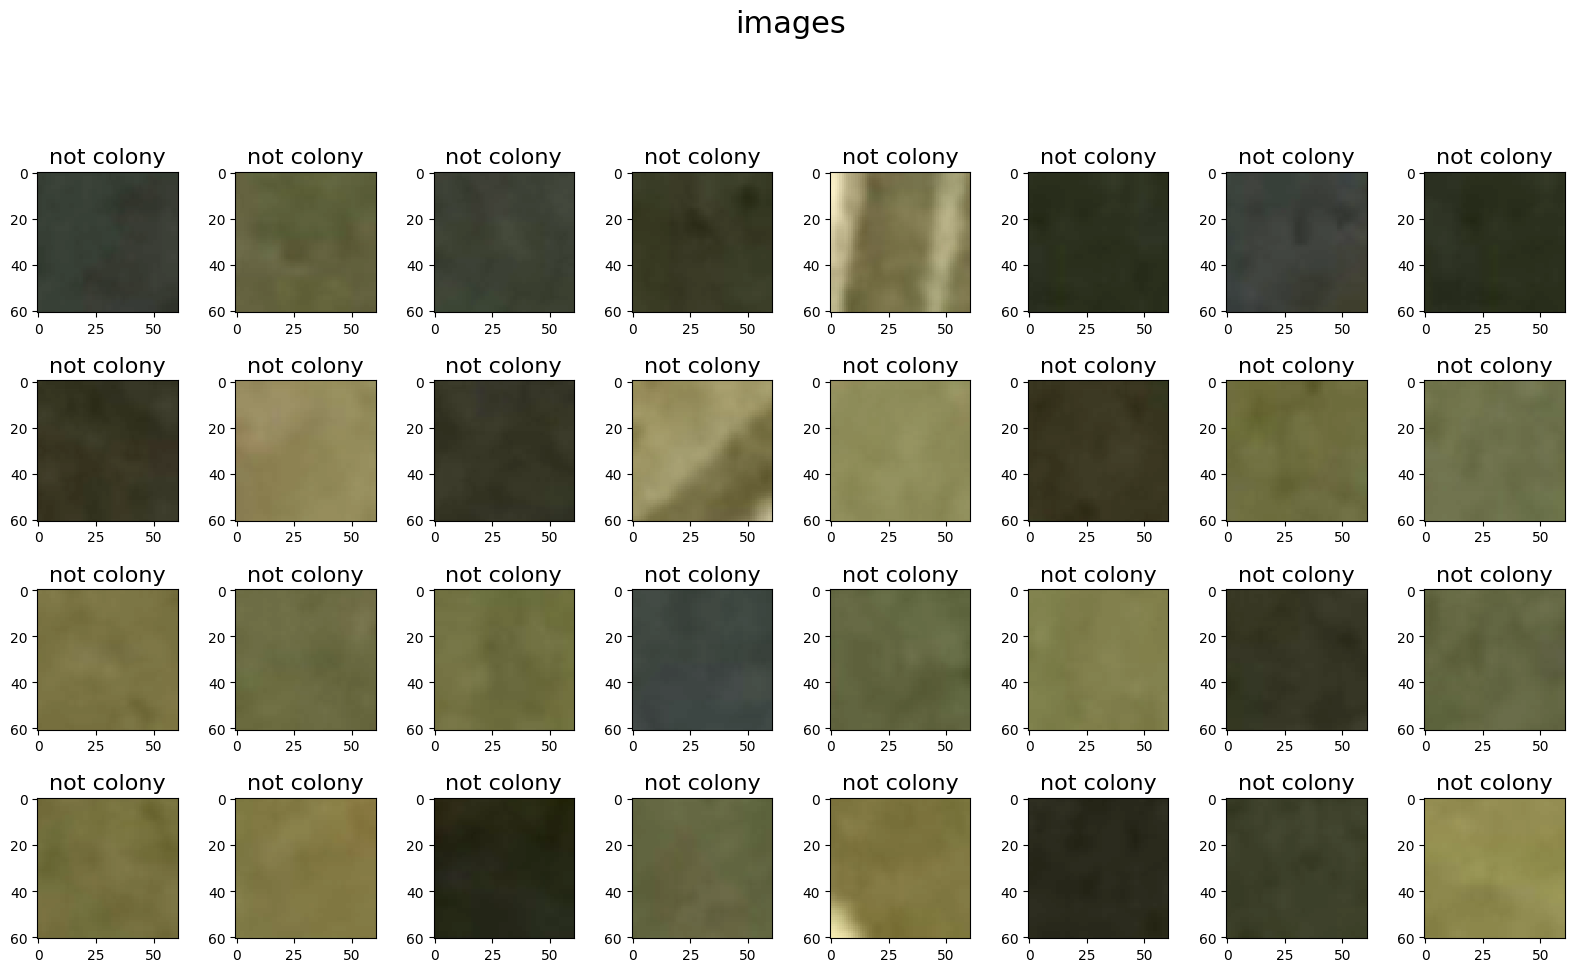

In [6]:
# Plot a batch.
inputs, outputs = images_masks.get_batch(4*8)
visualization.show_image_grid(inputs * 255, 4, 8, 2.5*4, 16, "images",
                              [("colony" if outputs[i] == 1 else "not colony") for i in range(outputs.shape[0])])

In [7]:
# Split the dataset.
train, test = images_masks.split(0.4)

In [8]:
# Create the net.
import tensorflow as tf
net = convnet1.ConvNet1("saves/18-01-16-PM-09-07", 120, train.size())

INFO:tensorflow:Using config: {'_model_dir': 'saves/18-01-16-PM-09-07', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': None, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff6701dc0f0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
# Create some metrics.
train_data = train.get_batch(1000)
test_data = test.get_batch(1000)
def loss_fn(predicted, actual):
    loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(actual, tf.int32), 3), predicted)
    with tf.Session().as_default():
        return loss.eval()
metrics = {
    "train_loss": metric.LossMetric(train_data, loss_fn),
    "test_loss": metric.LossMetric(test_data, loss_fn),
    "pred_thpt": metric.PredictionThroughputMetric(test_data)
}

In [11]:
# Make a function for plotting the metrics.
def plot_metrics():
    xs, ys = metrics["train_loss"].get_results()
    visualization.plot_line(xs, ys, "Training Loss", "training examples seen", "cross-entropy loss on training data",
                            3, 10)
    xs, ys = metrics["test_loss"].get_results()
    visualization.plot_line(xs, ys, "Test Loss", "training examples seen", "cross-entropy loss on test data", 3, 10)
    xs, ys = metrics["pred_thpt"].get_results()
    visualization.plot_line(xs, ys, "Training Throughput", "training examples seen", "speed of training in examples/s",
                            3, 10)

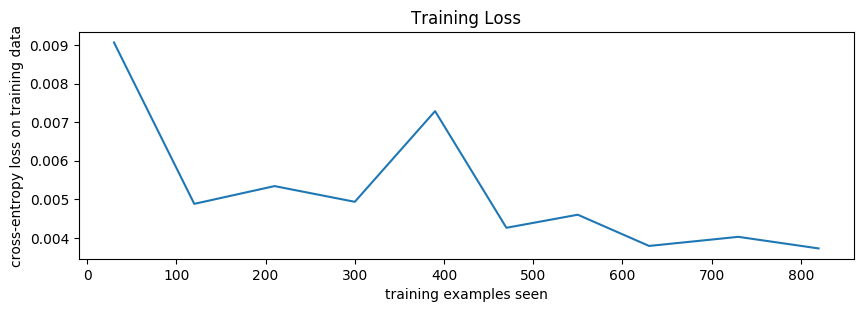

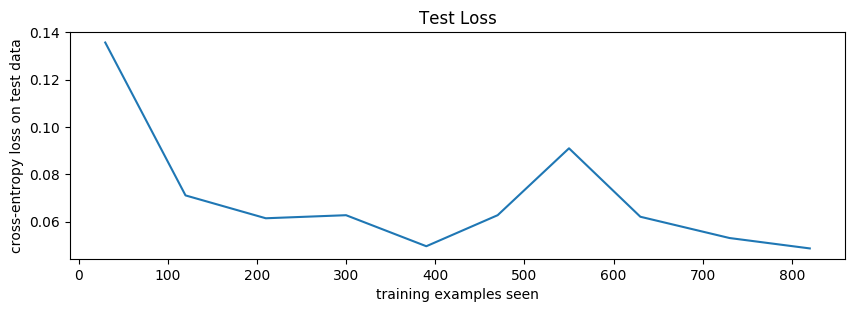

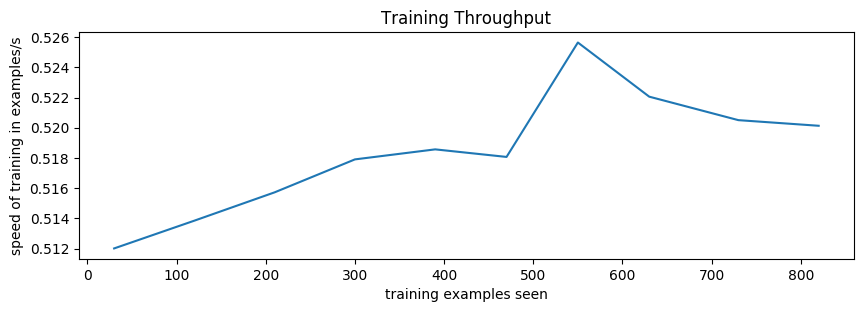

In [12]:
# Alternately train and evaluate the net for 20 minutes.
for _ in range(10):
    net.train(train, 3*60)
    net.evaluate(metrics)
    display.clear_output()
    plot_metrics()

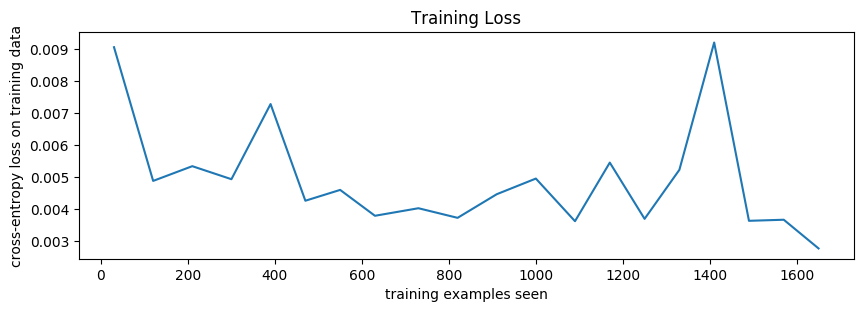

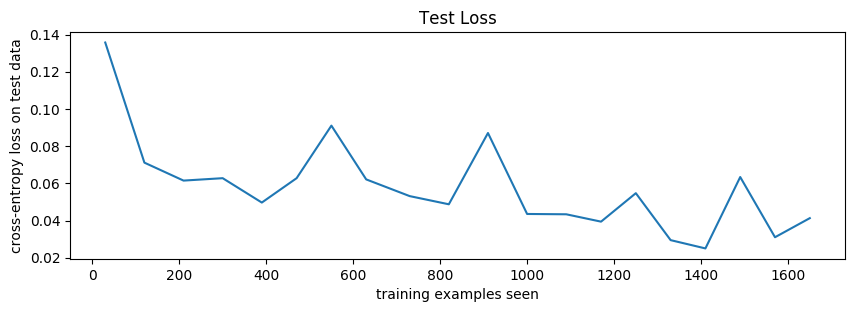

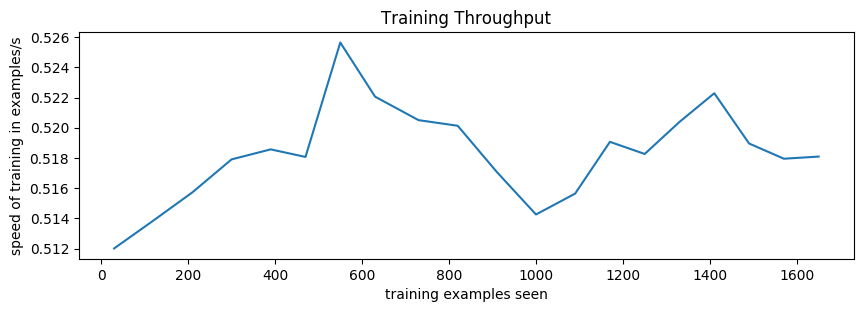

In [13]:
# Alternately train and evaluate the net for 20 minutes.
for _ in range(10):
    net.train(train, 3*60)
    net.evaluate(metrics)
    display.clear_output()
    plot_metrics()

In [ ]:
# Close the dataset.
microbia_segments.close()